# Building a Transformer from Scratch — GAIA Week 3 Seminar
## Training a Character-Level GPT on ვეფხისტყაოსანი

**GAIA Student AI Club — Foundations Course**\
**Seminar Date:** February 15, 2026\
**Seminar Leader:** Luka Barbakadze

---

### What We'll Build Together Today

We will **implement a complete Transformer language model from scratch** using only PyTorch, and train it on **ვეფხისტყაოსანი** (The Knight in the Panther's Skin).

**Format:** This is a **live-coding** seminar. Cells marked with 🔨 have `TODO` stubs — we'll write that code together, test it, check shapes, and build up piece by piece.

**Roadmap:**
1. **Theory Recap** — Transformer architecture, self-attention, encoder vs decoder
2. **🔨 Character-Level Tokenizer** — Build `encode()` / `decode()` for Georgian text
3. **🔨 Self-Attention from First Principles** — From weighted averaging to Q, K, V
4. **🔨 Full Transformer Assembly** — Head → MultiHead → Block → GPT
5. **🔨 Train & Generate** — Watch our model learn Georgian poetry patterns live
6. **Bonus** — Transformer variants: BERT, GPT, Vision Transformer (ViT)

> **Prerequisites:** You've watched the GAIA Transformer, BERT, and GPT lectures, and completed HW Part 1 (BERT fine-tuning) and HW Part 2 (scaled dot-product attention).

---
# Part 0: Setup & Theory Recap ⏱️ ~15 min
---

## 0.1 The Transformer Architecture — Step by Step

---

<img src="images/transformer.webp" width="500">

---

### **Step 1: Tokenization**

| Input Text | → | Characters | → | Token IDs |
|:----------:|:-:|:----------:|:-:|:---------:|
| `"Hello"` | → | `H`, `e`, `l`, `l`, `o` | → | `[7, 4, 11, 11, 14]` |

**Vocabulary lookup table:**
| char | `H` | `e` | `l` | `o` | `W` | `r` | `d` | ... |
|:----:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| id   |  7  |  4  | 11  | 14  | 22  | 17  |  3  | ... |


## 0.2 Mathematical Formulation — A Complete Example

Let's trace through a **single forward pass** with concrete dimensions. We'll use a tiny example: sequence length $T=3$, embedding dimension $d=4$.

---

### **Notation & Definitions**

| Symbol | Description | Shape |
|:------:|:------------|:-----:|
| $V$ | Vocabulary size | scalar |
| $T$ | Sequence length (number of tokens) | scalar |
| $d$ | Model dimension (embedding size) | scalar |
| $h$ | Number of attention heads | scalar |
| $d_k = d/h$ | Dimension per head | scalar |
| $\mathbf{E} \in \mathbb{R}^{V \times d}$ | Token embedding matrix | $(V, d)$ |
| $\mathbf{P} \in \mathbb{R}^{T_{max} \times d}$ | Position embedding matrix | $(T_{max}, d)$ |
| $\mathbf{W}^Q, \mathbf{W}^K, \mathbf{W}^V \in \mathbb{R}^{d \times d_k}$ | Query, Key, Value projections | $(d, d_k)$ |
| $\mathbf{W}^O \in \mathbb{R}^{d \times d}$ | Output projection | $(d, d)$ |


### **Step 1: Input Embedding**

Given input token IDs $[t_0, t_1, t_2] = [7, 4, 11]$ (e.g., "H", "e", "l"):

$$
\mathbf{X} = \mathbf{E}[t_0, t_1, t_2] + \mathbf{P}[0, 1, 2] \in \mathbb{R}^{T \times d}
$$

**Concrete example** with $T=3, d=4$:

$$
\mathbf{X} = \underbrace{\begin{bmatrix} -0.23 & 0.45 & -0.67 & 0.89 \\ 0.12 & -0.34 & 0.56 & 0.78 \\ 0.11 & 0.22 & -0.33 & 0.44 \end{bmatrix}}_{\text{Token Embeddings } (3 \times 4)} + \underbrace{\begin{bmatrix} 0.0 & 0.0 & 1.0 & 1.0 \\ 0.84 & 0.54 & 0.54 & -0.84 \\ 0.91 & -0.42 & -0.42 & -0.91 \end{bmatrix}}_{\text{Position Embeddings } (3 \times 4)} = \begin{bmatrix} -0.23 & 0.45 & 0.33 & 1.89 \\ 0.96 & 0.20 & 1.10 & -0.06 \\ 1.02 & -0.20 & -0.75 & -0.47 \end{bmatrix}
$$


<img src="images/tokenization_embeddings.webp" width="600">

### **Step 2: Query, Key, Value Projections**

For a single attention head, project $\mathbf{X}$ to queries, keys, and values:

$$
\mathbf{Q} = \mathbf{X} \mathbf{W}^Q \in \mathbb{R}^{T \times d_k}, \quad
\mathbf{K} = \mathbf{X} \mathbf{W}^K \in \mathbb{R}^{T \times d_k}, \quad
\mathbf{V} = \mathbf{X} \mathbf{W}^V \in \mathbb{R}^{T \times d_k}
$$

With $d_k = 4$ (single head for simplicity):

$$
\mathbf{Q} = \begin{bmatrix} \mathbf{q}_0 \\ \mathbf{q}_1 \\ \mathbf{q}_2 \end{bmatrix} = \begin{bmatrix} 0.5 & -0.3 & 0.8 & 0.1 \\ -0.2 & 0.7 & 0.4 & -0.5 \\ 0.3 & 0.1 & -0.6 & 0.9 \end{bmatrix}, \quad
\mathbf{K} = \begin{bmatrix} \mathbf{k}_0 \\ \mathbf{k}_1 \\ \mathbf{k}_2 \end{bmatrix} = \begin{bmatrix} 0.4 & 0.2 & -0.1 & 0.6 \\ -0.3 & 0.5 & 0.7 & 0.2 \\ 0.1 & -0.4 & 0.3 & -0.8 \end{bmatrix}
$$


### **Step 3: Scaled Dot-Product Attention**

**3a. Compute attention scores:**

$$
\mathbf{S} = \frac{\mathbf{Q} \mathbf{K}^\top}{\sqrt{d_k}} \in \mathbb{R}^{T \times T}
$$

$$
\mathbf{S} = \frac{1}{\sqrt{4}} \begin{bmatrix} \mathbf{q}_0 \cdot \mathbf{k}_0 & \mathbf{q}_0 \cdot \mathbf{k}_1 & \mathbf{q}_0 \cdot \mathbf{k}_2 \\ \mathbf{q}_1 \cdot \mathbf{k}_0 & \mathbf{q}_1 \cdot \mathbf{k}_1 & \mathbf{q}_1 \cdot \mathbf{k}_2 \\ \mathbf{q}_2 \cdot \mathbf{k}_0 & \mathbf{q}_2 \cdot \mathbf{k}_1 & \mathbf{q}_2 \cdot \mathbf{k}_2 \end{bmatrix} = \frac{1}{2} \begin{bmatrix} 0.52 & 0.71 & -0.65 \\ 0.03 & 0.86 & -0.12 \\ 0.73 & -0.21 & -0.88 \end{bmatrix} = \begin{bmatrix} 0.26 & 0.36 & -0.33 \\ 0.02 & 0.43 & -0.06 \\ 0.37 & -0.11 & -0.44 \end{bmatrix}
$$


**3b. Apply causal mask** (for GPT-style autoregressive model):

$$
\mathbf{M} = \begin{bmatrix} 0 & -\infty & -\infty \\ 0 & 0 & -\infty \\ 0 & 0 & 0 \end{bmatrix}, \quad \mathbf{S}_{\text{masked}} = \mathbf{S} + \mathbf{M} = \begin{bmatrix} 0.26 & -\infty & -\infty \\ 0.02 & 0.43 & -\infty \\ 0.37 & -0.11 & -0.44 \end{bmatrix}
$$

**3c. Apply softmax** (row-wise):

$$
\mathbf{A} = \text{softmax}(\mathbf{S}_{\text{masked}}) = \begin{bmatrix} 1.00 & 0 & 0 \\ 0.40 & 0.60 & 0 \\ 0.52 & 0.32 & 0.23 \end{bmatrix}
$$

> Row $i$ sums to 1 and represents the attention distribution for token $i$.

**3d. Compute weighted sum of values:**

$$
\mathbf{Z} = \mathbf{A} \mathbf{V} \in \mathbb{R}^{T \times d_k}
$$

$$
\mathbf{z}_0 = 1.00 \cdot \mathbf{v}_0 + 0 \cdot \mathbf{v}_1 + 0 \cdot \mathbf{v}_2 = \mathbf{v}_0 \quad \text{(only sees itself)}
$$

$$
\mathbf{z}_1 = 0.40 \cdot \mathbf{v}_0 + 0.60 \cdot \mathbf{v}_1 + 0 \cdot \mathbf{v}_2 \quad \text{(weighted mix of past)}
$$

$$
\mathbf{z}_2 = 0.52 \cdot \mathbf{v}_0 + 0.32 \cdot \mathbf{v}_1 + 0.23 \cdot \mathbf{v}_2 \quad \text{(sees all previous)}
$$

### **Step 4: Multi-Head Attention**

With $h$ heads, we run the above in parallel with different $\mathbf{W}^Q_i, \mathbf{W}^K_i, \mathbf{W}^V_i$:

$$
\text{head}_i = \text{Attention}(\mathbf{X}\mathbf{W}^Q_i, \mathbf{X}\mathbf{W}^K_i, \mathbf{X}\mathbf{W}^V_i) \in \mathbb{R}^{T \times d_k}
$$

$$
\text{MultiHead}(\mathbf{X}) = \text{Concat}(\text{head}_1, \ldots, \text{head}_h) \mathbf{W}^O \in \mathbb{R}^{T \times d}
$$


### **Step 5: Feed-Forward Network**

Applied position-wise (same MLP to each token independently):

$$
\text{FFN}(\mathbf{x}) = \text{ReLU}(\mathbf{x} \mathbf{W}_1 + \mathbf{b}_1) \mathbf{W}_2 + \mathbf{b}_2
$$

Where $\mathbf{W}_1 \in \mathbb{R}^{d \times 4d}$, $\mathbf{W}_2 \in \mathbb{R}^{4d \times d}$ (expand then contract).


### **Step 6: Transformer Block with Residuals**

$$
\mathbf{X}' = \mathbf{X} + \text{MultiHead}(\text{LayerNorm}(\mathbf{X}))
$$

$$
\mathbf{X}'' = \mathbf{X}' + \text{FFN}(\text{LayerNorm}(\mathbf{X}'))
$$

### **Step 7: Output Logits**

After $N$ blocks, project to vocabulary:

$$
\text{logits} = \mathbf{X}^{(N)} \mathbf{W}_{\text{vocab}} \in \mathbb{R}^{T \times V}
$$

For next-token prediction, we take $\text{logits}[-1]$ (last position) and apply softmax:

$$
P(\text{next token} = w) = \frac{\exp(\text{logits}_{T-1, w})}{\sum_{w'} \exp(\text{logits}_{T-1, w'})}
$$

### **Complete Single-Head Attention Formula**

$$
\boxed{\text{Attention}(\mathbf{Q}, \mathbf{K}, \mathbf{V}) = \text{softmax}\left( \frac{\mathbf{Q}\mathbf{K}^\top}{\sqrt{d_k}} + \mathbf{M} \right) \mathbf{V}}
$$

Where $\mathbf{M}_{ij} = \begin{cases} 0 & \text{if } i \geq j \\ -\infty & \text{if } i < j \end{cases}$ for causal (GPT) attention.

### Visual: GPT vs BERT — The Causal Mask

**Self-Attention (BERT) vs Masked Self-Attention (GPT):**

<img src="images/attention_mask.webp">

---

<img src="https://jalammar.github.io/images/gpt2/self-attention-and-masked-self-attention.png" width="700">

**The triangular attention mask in action:**

**The ONLY architectural difference:** GPT uses a triangular mask (can't see future), BERT sees everything. One line of code!

In [1]:
# Setup — run this first
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

PyTorch version: 2.10.0
CUDA available: False
Using device: cpu


---
# Part 1: Data & Character-Level Tokenizer
---

We'll train our transformer on **ვეფხისტყაოსანი** ("The Knight in the Panther's Skin") — a 12th-century epic poem by **Shota Rustaveli**, considered the crown jewel of Georgian literature.

**Why this dataset?**
- It's in **Georgian** — a unique alphabet perfect for character-level modeling
- It's ~8,500 lines of structured poetry — enough patterns for a small model to learn
- It's culturally meaningful — generating new "verses" is a fun demo

**Tokenization approach: Character-level**
- Simplest possible tokenizer — each unique character gets an integer ID
- Compare to what BERT/GPT actually use:
  - **Word-level:** Large vocab, OOV (out-of-vocabulary) problem
  - **Subword (BPE/WordPiece):** Balance between char & word — what you used in HW Part 1 with `AutoTokenizer`
  - **Character-level:** Tiny vocab, long sequences, but captures everything
- For our demo, character-level is perfect — small vocab, easy to understand

In [2]:
# Download the dataset (ვეფხისტყაოსანი)
# We host it as a raw text file for easy access in Colab
!wget -q https://raw.githubusercontent.com/luka-bzh/gaia-seminar/main/vefxistyaosani.txt -O vefxistyaosani.txt 2>/dev/null || echo "Download failed — uploading manually instead"

# If the download fails, upload the file manually to Colab:
# Option A: Use the file browser on the left panel
# Option B: Uncomment and run:
# from google.colab import files
# uploaded = files.upload()  # select vefxistyaosani.txt

with open('vefxistyaosani.txt', 'r', encoding='utf-8') as f:
    text = f.read()

print(f"Dataset: ვეფხისტყაოსანი (The Knight in the Panther's Skin)")
print(f"Total characters: {len(text):,}")
print(f"Total lines: {text.count(chr(10)):,}")
print(f"\n--- First 300 characters ---")
print(text[:300])

Download failed — uploading manually instead
Dataset: ვეფხისტყაოსანი (The Knight in the Panther's Skin)
Total characters: 329,322
Total lines: 8,525

--- First 300 characters ---
ვეფხისტყაოსანი
დასაწყისი

რომელმან შექმნა სამყარო ძალითა მით ძლიერითა,
ზეგარდმო არსნი სულითა ყვნა ზეცით მონაბერითა,
ჩვენ, კაცთა, მოგვცა ქვეყანა, გვაქვს უთვალავი ფერითა,
და მისგან არს ყოვლი ხელმწიფე სახითა მის მიერითა.

ჰე, ღმერთო ერთო, შენ შეჰქმენ სახე ყოვლისა ტანისა,
შენ დამიფარე, ძლევა მეც დათრგუნ


## 🔨 Let's Build a Tokenizer

We need a way to convert Georgian characters to numbers (and back). Our tokenizer will:
1. Find all unique characters in the text → our **vocabulary**
2. Create `stoi` (string→int) and `itos` (int→string) lookup dictionaries
3. Write `encode(s)` and `decode(l)` functions

This is the simplest possible tokenizer — compare to BPE/WordPiece used in real models like BERT (which you used in HW Part 1 with `AutoTokenizer`).

# ============================================================
# 🔨 LIVE CODE: Build the character-level tokenizer
# ============================================================

In [3]:
# Step 1: Find all unique characters in the text
chars = sorted(list(set(text)))
vocab_size = len(chars)

print(f"Vocabulary size: {vocab_size} unique characters")
print(f"Characters: {''.join(chars)}")
print()

# Step 2: Create character <-> integer mappings
# TODO: Create two dictionaries:
#   stoi — maps each character to a unique integer (string to int)
#   itos — maps each integer back to its character (int to string)
# Hint: use enumerate(chars)

stoi = {ch: i for i, ch in enumerate(chars)}  # {char: index}
itos = {i: ch for i, ch in enumerate(chars)}  # {index: char}

# Step 3: Encoder and decoder functions
# TODO: encode(s) → takes a string, returns list of integers
# TODO: decode(l) → takes a list of integers, returns a string

def encode(s):
    """Convert a string to a list of integers."""
    return [stoi[c] for c in s]

def decode(l):
    """Convert a list of integers back to a string."""
    return ''.join([itos[i] for i in l])

Vocabulary size: 49 unique characters
Characters: 
 !",-.:;?«»აბგდევზთიკლმნოპჟრსტუფქღყშჩცძწჭხჯჰ–—“”



In [4]:
# Step 1: Find all unique characters in the text
chars = sorted(list(set(text)))
vocab_size = len(chars)

print(chars)
print(f"Vocabulary size: {vocab_size} unique characters")
print(f"Characters: {''.join(chars)}")
print()

# Step 2: Create character <-> integer mappings
# TODO: Create two dictionaries:
#   stoi — maps each character to a unique integer (string to int)
#   itos — maps each integer back to its character (int to string)
# Hint: use enumerate(chars)

stoi = {ch: i for i, ch in enumerate(chars)}  # {char: index}
itos = {i: ch for i, ch in enumerate(chars)}  # {index: char}

# Step 3: Encoder and decoder functions
# TODO: encode(s) → takes a string, returns list of integers
# TODO: decode(l) → takes a list of integers, returns a string

def encode(s):
    """Convert a string to a list of integers."""
    return [stoi[c] for c in s]

def decode(l):
    """Convert a list of integers back to a string."""
    return ''.join([itos[i] for i in l])

['\n', ' ', '!', '"', ',', '-', '.', ':', ';', '?', '«', '»', 'ა', 'ბ', 'გ', 'დ', 'ე', 'ვ', 'ზ', 'თ', 'ი', 'კ', 'ლ', 'მ', 'ნ', 'ო', 'პ', 'ჟ', 'რ', 'ს', 'ტ', 'უ', 'ფ', 'ქ', 'ღ', 'ყ', 'შ', 'ჩ', 'ც', 'ძ', 'წ', 'ჭ', 'ხ', 'ჯ', 'ჰ', '–', '—', '“', '”']
Vocabulary size: 49 unique characters
Characters: 
 !",-.:;?«»აბგდევზთიკლმნოპჟრსტუფქღყშჩცძწჭხჯჰ–—“”



In [5]:
# ✅ TEST: Verify our tokenizer works
test_str = "ვეფხისტყაოსანი"
encoded = encode(test_str)
decoded = decode(encoded)

print(f"Original:  '{test_str}'")
print(f"Encoded:   {encoded}")
print(f"Decoded:   '{decoded}'")
print(f"Roundtrip: {test_str == decoded}")
assert test_str == decoded, "❌ Roundtrip failed! Check encode/decode."
print("✅ Tokenizer roundtrip works!\n")

Original:  'ვეფხისტყაოსანი'
Encoded:   [17, 16, 32, 42, 20, 29, 30, 35, 12, 25, 29, 12, 24, 20]
Decoded:   'ვეფხისტყაოსანი'
Roundtrip: True
✅ Tokenizer roundtrip works!



In [6]:
# Let's also check a few mappings
print("Sample mappings:")
for ch in "ვეფხის":
    print(f"  '{ch}' → {stoi[ch]} → '{itos[stoi[ch]]}'")

print(f"\nFirst 5 chars in vocab: {chars[:5]}")
print(f"Last 5 chars in vocab:  {chars[-5:]}")

Sample mappings:
  'ვ' → 17 → 'ვ'
  'ე' → 16 → 'ე'
  'ფ' → 32 → 'ფ'
  'ხ' → 42 → 'ხ'
  'ი' → 20 → 'ი'
  'ს' → 29 → 'ს'

First 5 chars in vocab: ['\n', ' ', '!', '"', ',']
Last 5 chars in vocab:  ['ჰ', '–', '—', '“', '”']


In [7]:
# ============================================================
# 🔨 LIVE CODE: Encode the dataset and create train/val split
# ============================================================

# TODO: Encode the entire text into a tensor of integers using our encode() function
# Hint: wrap the result in torch.tensor(..., dtype=torch.long)
data = torch.tensor(encode(text), dtype=torch.long)

print(f"Encoded dataset shape: {data.shape}")
print(f"dtype: {data.dtype}")
print(f"First 20 token IDs: {data[:20].tolist()}")
print(f"Decoded back: '{decode(data[:20].tolist())}'")

# TODO: Split into 90% train, 10% validation
# Hint: n = int(0.9 * len(data)), then slice
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

print(f"\nTrain size: {len(train_data):,} characters")
print(f"Val size:   {len(val_data):,} characters")
print(f"Total:      {len(train_data) + len(val_data):,}")

Encoded dataset shape: torch.Size([329322])
dtype: torch.int64
First 20 token IDs: [17, 16, 32, 42, 20, 29, 30, 35, 12, 25, 29, 12, 24, 20, 0, 15, 12, 29, 12, 40]
Decoded back: 'ვეფხისტყაოსანი
დასაწ'

Train size: 296,389 characters
Val size:   32,933 characters
Total:      329,322


In [8]:
# Hyperparameters — we'll use these throughout
# (Defined here so we can reference them everywhere)

batch_size = 32       # how many independent sequences to process in parallel
block_size = 128      # maximum context length for predictions
n_embd = 128          # embedding dimension
n_head = 4            # number of attention heads
n_layer = 4           # number of transformer blocks
dropout = 0.2         # dropout rate
learning_rate = 3e-4  # optimizer learning rate
max_iters = 5000      # total training iterations
eval_interval = 250   # how often to evaluate
eval_iters = 200      # how many batches to average for eval loss

torch.manual_seed(1337)

# Data loading: create random batches of context windows
def get_batch(split):
    """Generate a small batch of inputs (x) and targets (y)."""
    data = train_data if split == 'train' else val_data
    # Random starting indices
    ix = torch.randint(len(data) - block_size, (batch_size,))
    # Stack into batches
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

print("Hyperparameters:")
print(f"  batch_size   = {batch_size}")
print(f"  block_size   = {block_size}  (context window)")
print(f"  n_embd       = {n_embd}   (embedding dimension)")
print(f"  n_head       = {n_head}     (attention heads)")
print(f"  n_layer      = {n_layer}     (transformer blocks)")
print(f"  dropout      = {dropout}")
print(f"  learning_rate= {learning_rate}")
print(f"  max_iters    = {max_iters}")
print(f"  vocab_size   = {vocab_size}  (from tokenizer)")

Hyperparameters:
  batch_size   = 32
  block_size   = 128  (context window)
  n_embd       = 128   (embedding dimension)
  n_head       = 4     (attention heads)
  n_layer      = 4     (transformer blocks)
  dropout      = 0.2
  learning_rate= 0.0003
  max_iters    = 5000
  vocab_size   = 49  (from tokenizer)


In [9]:
# ✅ TEST: Verify get_batch works
xb, yb = get_batch('train')

print(f"Input batch shape:  {xb.shape}  — expected: ({batch_size}, {block_size})")
print(f"Target batch shape: {yb.shape}  — expected: ({batch_size}, {block_size})")
assert xb.shape == (batch_size, block_size), f"❌ Wrong shape: {xb.shape}"
assert yb.shape == (batch_size, block_size), f"❌ Wrong shape: {yb.shape}"
print("✅ Shapes correct!\n")

# Verify the target is the input shifted by 1
print("Sanity check — target should be input shifted right by 1:")
print(f"  Input[0, :10]:  {xb[0, :10].tolist()}")
print(f"  Target[0, :10]: {yb[0, :10].tolist()}")
print(f"\n  Decoded input:  '{decode(xb[0, :20].tolist())}'")
print(f"  Decoded target: '{decode(yb[0, :20].tolist())}'")
print("\nNotice: each target character is the NEXT character after the input!")

Input batch shape:  torch.Size([32, 128])  — expected: (32, 128)
Target batch shape: torch.Size([32, 128])  — expected: (32, 128)
✅ Shapes correct!

Sanity check — target should be input shifted right by 1:
  Input[0, :10]:  [0, 20, 30, 35, 17, 20, 29, 4, 1, 19]
  Target[0, :10]: [20, 30, 35, 17, 20, 29, 4, 1, 19, 31]

  Decoded input:  '
იტყვის, თუ: “ღვარი '
  Decoded target: 'იტყვის, თუ: “ღვარი ს'

Notice: each target character is the NEXT character after the input!


In [10]:
@torch.no_grad()
def estimate_loss():
    """Estimate train and val loss by averaging over eval_iters batches."""
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

---
# Part 2: Self-Attention from First Principles
---

This is the **most important section** of the seminar. We'll build up to self-attention step by step:

1. **Naive averaging** — each token gets the mean of all previous tokens (for loop)
2. **Matrix-multiply trick** — same thing, but using a lower-triangular matrix
3. **Softmax formulation** — replace uniform weights with softmax (opens the door to learning)
4. **Learned attention** — introduce Q, K, V projections → full self-attention

> 💡 This progression mirrors how the concept was developed: from simple aggregation to the powerful attention mechanism.

$$
\mathbf{S} = \frac{\mathbf{Q} \mathbf{K}^\top}{\sqrt{d_k}} \in \mathbb{R}^{T \times T}
$$

*The full attention flow: Q and K produce scores → scale → mask future → softmax → multiply by V → output. Each step has a clear purpose.*

In [11]:
# Step 1: The problem — we want each token to "know about" previous tokens
# Naive approach: for each position t, average all embeddings from 0..t

torch.manual_seed(42)
B, T, C = 4, 8, 2  # batch=4, time/seq_len=8, channels/embed_dim=2
x = torch.randn(B, T, C)

# Slow version: explicit loop
xbow = torch.zeros((B, T, C))  # "bag of words" — weighted average
for b in range(B):
    for t in range(T):
        xprev = x[b, :t+1]           # all tokens from 0 to t: shape (t+1, C)
        xbow[b, t] = torch.mean(xprev, dim=0)  # average them

print("x[0] (raw token embeddings):")
print(x[0])
print("\nxbow[0] (cumulative averages):")
print(xbow[0])
print("\nNotice: row 0 = x[0,0] itself; row 1 = avg(row0, row1); row 2 = avg(row0,row1,row2); etc.")

x[0] (raw token embeddings):
tensor([[ 1.9269,  1.4873],
        [ 0.9007, -2.1055],
        [ 0.6784, -1.2345],
        [-0.0431, -1.6047],
        [-0.7521,  1.6487],
        [-0.3925, -1.4036],
        [-0.7279, -0.5594],
        [-0.7688,  0.7624]])

xbow[0] (cumulative averages):
tensor([[ 1.9269,  1.4873],
        [ 1.4138, -0.3091],
        [ 1.1687, -0.6176],
        [ 0.8657, -0.8644],
        [ 0.5422, -0.3617],
        [ 0.3864, -0.5354],
        [ 0.2272, -0.5388],
        [ 0.1027, -0.3762]])

Notice: row 0 = x[0,0] itself; row 1 = avg(row0, row1); row 2 = avg(row0,row1,row2); etc.


In [12]:
# Step 2: The matrix-multiply trick — same result, but vectorized!
# Key insight: cumulative averaging = multiplying by a lower-triangular matrix

wei = torch.tril(torch.ones(T, T))  # lower-triangular matrix of ones
wei = wei / wei.sum(dim=1, keepdim=True)  # normalize rows to sum to 1


| Row | Description | Weights |
|-----|-------------|---------|
| 0 | Only look at yourself | [1, 0, 0, ...] |
| 1 | Average of positions 0 and 1 | [0.5, 0.5, 0, ...] |
| 2 | Average of positions 0, 1, 2 | [0.33, 0.33, 0.33, 0, ...] |
| ... | ... | ... |


In [13]:
# Matrix multiply: (T, T) @ (B, T, C) → (B, T, C)
xbow2 = wei @ x  # broadcasting handles the batch dimension

# Verify: same result as the loop!
print(f"\nAre results identical? {torch.allclose(xbow, xbow2)}")



Are results identical? True


print("Weights via softmax (same result!):")
print(wei)

xbow3 = wei @ x
print(f"\nSame as before? {torch.allclose(xbow, xbow3)}")

print("""
KEY INSIGHT: Right now the weights before softmax are all zeros (uniform).
But what if we REPLACED those zeros with LEARNED scores that depend on the data?
→ Some tokens would get MORE attention than others
→ This is exactly what self-attention does!
""")

In [14]:
# Step 3: Softmax formulation — the gateway to LEARNING the weights
# Instead of fixed uniform weights, use softmax to create the same pattern

tril = torch.tril(torch.ones(T, T))
wei = torch.zeros((T, T))
wei = wei.masked_fill(tril == 0, float('-inf'))  # future positions → -inf
wei = F.softmax(wei, dim=-1)                      # softmax normalizes to probabilities


In [15]:
# Step 4: Self-Attention! — data-dependent weights via Q, K, V

torch.manual_seed(1337)
B, T, C = 4, 8, 32  # now with a realistic embedding dimension
x = torch.randn(B, T, C)

# Each token produces a Query, Key, and Value vector
head_size = 16
key   = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)

k = key(x)    # (B, T, head_size)
q = query(x)  # (B, T, head_size)

# Attention scores: how much should token i attend to token j?
# Q @ K^T → (B, T, T) — pairwise similarity scores
wei = q @ k.transpose(-2, -1)  # (B, T, head_size) @ (B, head_size, T) → (B, T, T)

# Scale by sqrt(head_size) to keep variance ~1
wei = wei * head_size**-0.5

# Apply causal mask — THIS is what makes it a DECODER (GPT-style)
tril = torch.tril(torch.ones(T, T))
wei = wei.masked_fill(tril == 0, float('-inf'))

# Softmax → attention probabilities
wei = F.softmax(wei, dim=-1)

# Weighted sum of values
v = value(x)   # (B, T, head_size)
out = wei @ v   # (B, T, T) @ (B, T, head_size) → (B, T, head_size)

print(f"Output shape: {out.shape}")
print(f"\nAttention weights for first example (row = query, col = key):")
print(f"Notice the triangular pattern — each token only attends to previous tokens!")
print(wei[0].detach())

# ✅ TEST: Verify self-attention output
print(f"\nk shape: {k.shape}  — expected: ({B}, {T}, {head_size})")
print(f"q shape: {q.shape}  — expected: ({B}, {T}, {head_size})")
print(f"wei shape: {wei.shape}  — expected: ({B}, {T}, {T})")
print(f"v shape: {v.shape}  — expected: ({B}, {T}, {head_size})")
print(f"out shape: {out.shape}  — expected: ({B}, {T}, {head_size})")

# Check: each row of attention weights sums to 1
row_sums = wei[0].sum(dim=-1)
print(f"\nAttention row sums (should all be ~1.0): {row_sums.detach()}")

print("\nNotice the triangular pattern — each token only attends to past tokens!")

Output shape: torch.Size([4, 8, 16])

Attention weights for first example (row = query, col = key):
Notice the triangular pattern — each token only attends to previous tokens!
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3966, 0.6034, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3069, 0.2892, 0.4039, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3233, 0.2175, 0.2443, 0.2149, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1479, 0.2034, 0.1663, 0.1455, 0.3369, 0.0000, 0.0000, 0.0000],
        [0.1259, 0.2490, 0.1324, 0.1062, 0.3141, 0.0724, 0.0000, 0.0000],
        [0.1598, 0.1990, 0.1140, 0.1125, 0.1418, 0.1669, 0.1061, 0.0000],
        [0.0845, 0.1197, 0.1078, 0.1537, 0.1086, 0.1146, 0.1558, 0.1553]])

k shape: torch.Size([4, 8, 16])  — expected: (4, 8, 16)
q shape: torch.Size([4, 8, 16])  — expected: (4, 8, 16)
wei shape: torch.Size([4, 8, 8])  — expected: (4, 8, 8)
v shape: torch.Size([4, 8, 16])  — expected: (4, 8, 16)
out sh

In [16]:
# ✅ TEST: Verify self-attention output
print(f"k shape: {k.shape}  — expected: ({B}, {T}, {head_size})")
print(f"q shape: {q.shape}  — expected: ({B}, {T}, {head_size})")
print(f"wei shape: {wei.shape}  — expected: ({B}, {T}, {T})")
print(f"v shape: {v.shape}  — expected: ({B}, {T}, {head_size})")
print(f"out shape: {out.shape}  — expected: ({B}, {T}, {head_size})")

# Check: each row of attention weights sums to 1
row_sums = wei[0].sum(dim=-1)
print(f"\nAttention row sums (should all be ~1.0): {row_sums.detach()}")

# Check: lower triangular (causal mask is working)
print(f"\nAttention weights for first example:")
print(wei[0].detach())
print("\nNotice the triangular pattern — each token only attends to past tokens!")

k shape: torch.Size([4, 8, 16])  — expected: (4, 8, 16)
q shape: torch.Size([4, 8, 16])  — expected: (4, 8, 16)
wei shape: torch.Size([4, 8, 8])  — expected: (4, 8, 8)
v shape: torch.Size([4, 8, 16])  — expected: (4, 8, 16)
out shape: torch.Size([4, 8, 16])  — expected: (4, 8, 16)

Attention row sums (should all be ~1.0): tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

Attention weights for first example:
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3966, 0.6034, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3069, 0.2892, 0.4039, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3233, 0.2175, 0.2443, 0.2149, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1479, 0.2034, 0.1663, 0.1455, 0.3369, 0.0000, 0.0000, 0.0000],
        [0.1259, 0.2490, 0.1324, 0.1062, 0.3141, 0.0724, 0.0000, 0.0000],
        [0.1598, 0.1990, 0.1140, 0.1125, 0.1418, 0.1669, 0.1061, 0.0000],
        [0.0845, 0.1197, 0.1078, 0.1537, 0.1086

---
# Part 3: Building the Full Transformer ⏱️ ~20 min
---

Now we assemble all the pieces into a complete GPT-style transformer. We'll build these components in order:

1. **`Head`** — A single self-attention head (what we just learned)
2. **`MultiHeadAttention`** — Run multiple heads in parallel, concatenate results
3. **`FeedForward`** — A simple 2-layer MLP (per-position processing)
4. **`Block`** — One transformer block = MultiHeadAttention + FeedForward + residuals + LayerNorm
5. **`GPTLanguageModel`** — The full model: embeddings → N blocks → output head

Each component is a small, self-contained `nn.Module`. The beauty of the transformer is its **modularity** — complex behavior emerges from simple, repeated blocks.

### Visual: Transformer Block Structure

*One block = Attention (communication) + FFN (computation), with LayerNorm and residual connections. This pattern repeats N times.*

In [17]:
# ============================================================
# 🔨 LIVE CODE: Component 1 — Single Attention Head
# ============================================================
# This is exactly what we just built, now wrapped in nn.Module

class Head(nn.Module):
    """One head of self-attention."""

    def __init__(self, head_size):
        super().__init__()
        self.key   = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        # tril is not a parameter — it's a fixed buffer (the causal mask)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        # TODO: This is the same self-attention we just coded above!
        # 1. Compute k, q from x
        # 2. Attention scores: q @ k^T, scaled by sqrt(head_size)
        # 3. Apply causal mask (self.tril[:T, :T])
        # 4. Softmax → dropout
        # 5. Weighted sum with values
        # Return shape: (B, T, head_size)
        
        k = self.key(x)    # (B, T, head_size)
        q = self.query(x)  # (B, T, head_size)
        
        # Compute attention scores — scale by sqrt(head_size), not C
        head_size = k.shape[-1]
        wei = q @ k.transpose(-2, -1) * head_size**-0.5  # (B, T, T)
        # Apply causal mask: prevent attending to future tokens
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)  # (B, T, T)
        wei = self.dropout(wei)
        
        # Weighted aggregation of values
        v = self.value(x)  # (B, T, head_size)
        out = wei @ v      # (B, T, head_size)
        return out

In [18]:
# ✅ TEST: Verify Head works
dummy_x = torch.randn(2, block_size, n_embd)  # (batch=2, T=block_size, C=n_embd)
test_head = Head(n_embd // n_head)
test_out = test_head(dummy_x)

print(f"Input shape:  {dummy_x.shape}  — (B, T, n_embd={n_embd})")
print(f"Output shape: {test_out.shape}  — expected: (2, {block_size}, {n_embd // n_head})")
assert test_out.shape == (2, block_size, n_embd // n_head), f"❌ Wrong shape: {test_out.shape}"
print("✅ Head works! Output dimension = head_size = n_embd // n_head")
del test_head, test_out, dummy_x

Input shape:  torch.Size([2, 128, 128])  — (B, T, n_embd=128)
Output shape: torch.Size([2, 128, 32])  — expected: (2, 128, 32)
✅ Head works! Output dimension = head_size = n_embd // n_head


In [19]:
# ============================================================
# 🔨 LIVE CODE: Component 2 — Multi-Head Attention
# ============================================================
# Instead of one attention head, we run multiple heads in parallel.
# Each head learns different attention patterns (e.g., one might focus on
# syntax, another on semantics, etc.)
#
# Architecture:
#   1. Run n_head attention heads in parallel (each with head_size = n_embd // n_head)
#   2. Concatenate their outputs → shape (B, T, n_embd)
#   3. Apply output projection (linear layer) and dropout

class MultiHeadAttention(nn.Module):
    """Multiple heads of self-attention in parallel."""

    def __init__(self, num_heads, head_size):
        super().__init__()
        # TODO: Create multiple attention heads
        # 1. Use nn.ModuleList to create num_heads Head instances
        # 2. Create output projection: Linear(n_embd, n_embd)
        # 3. Add dropout
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # TODO: Run all heads in parallel and concatenate
        # 1. Run each head on x: [head(x) for head in self.heads]
        # 2. Concatenate along the last dimension (dim=-1)
        # 3. Apply projection and dropout
        # Return shape: (B, T, n_embd)
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

In [20]:
# ============================================================
# 🔨 LIVE CODE: Component 3 — Feed-Forward Network (FFN)
# ============================================================
# After attention (tokens "talk" to each other), each token gets
# independent processing through a small MLP.
#
# Architecture: Linear(n_embd → 4*n_embd) → ReLU → Linear(4*n_embd → n_embd) → Dropout
# The 4× expansion gives the network more capacity for non-linear transformations.

class FeedForward(nn.Module):
    """A simple linear layer followed by a non-linearity."""

    def __init__(self, n_embd):
        super().__init__()
        # TODO: Build a Sequential network:
        #   1. Linear(n_embd, 4 * n_embd)   — expand
        #   2. ReLU()                         — non-linearity
        #   3. Linear(4 * n_embd, n_embd)   — contract back
        #   4. Dropout(dropout)
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

In [21]:
# ============================================================
# 🔨 LIVE CODE: Component 4 — Transformer Block
# ============================================================
# One block = MultiHeadAttention + FeedForward, with:
#   - Residual connections (skip connections) around each sub-layer
#   - LayerNorm before each sub-layer (Pre-Norm variant)
#
# Think of it as two phases:
#   1. COMMUNICATION: tokens talk to each other (attention)
#   2. COMPUTATION: each token processes independently (FFN)

class Block(nn.Module):
    """Transformer block: communication followed by computation."""

    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        # TODO: Implement the forward pass with residual connections
        # Pattern: x = x + sublayer(norm(x))
        #
        # Step 1: LayerNorm → self-attention → add residual (x + ...)
        # Step 2: LayerNorm → feed-forward → add residual (x + ...)
        #
        # Why residual connections? They let gradients flow through deep networks!
        # Why pre-norm (norm before sublayer)? More stable training than post-norm.
        
        # Residual connection: x + sublayer(norm(x))
        # This helps gradients flow through deep networks
        x = x + self.sa(self.ln1(x))     # attention + residual
        x = x + self.ffwd(self.ln2(x))   # FFN + residual
        return x

In [22]:
# ✅ TEST: Verify Block works
dummy_x = torch.randn(2, block_size, n_embd)
test_block = Block(n_embd, n_head)
test_out = test_block(dummy_x)

print(f"Input shape:  {dummy_x.shape}")
print(f"Output shape: {test_out.shape}  — expected: (2, {block_size}, {n_embd})")
assert test_out.shape == (2, block_size, n_embd), f"❌ Wrong shape: {test_out.shape}"
print("✅ Block works! Residual connections preserve shape.")
del test_block, test_out, dummy_x

Input shape:  torch.Size([2, 128, 128])
Output shape: torch.Size([2, 128, 128])  — expected: (2, 128, 128)
✅ Block works! Residual connections preserve shape.


In [23]:
# ============================================================
# 🔨 LIVE CODE: Component 5 — The Full GPT Language Model
# ============================================================
# Putting it all together:
#   1. Token embedding:    token_id → vector
#   2. Position embedding: position → vector (learned, not sinusoidal)
#   3. N Transformer Blocks: repeated self-attention + FFN
#   4. Final LayerNorm
#   5. Linear head: project back to vocab_size → logits for next token

class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # Embedding tables
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        # Transformer blocks
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        # Final layer norm
        self.ln_f = nn.LayerNorm(n_embd)
        # Output projection: from embedding space → vocabulary
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        """
        idx:     (B, T) tensor of token indices
        targets: (B, T) tensor of target token indices (optional)
        Returns: logits (B, T, vocab_size), loss (scalar or None)
        """
        B, T = idx.shape

        # Step 1 — Token embeddings + positional embeddings
        tok_emb = self.token_embedding_table(idx)                              # (B, T, n_embd)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T, n_embd)
        x = tok_emb + pos_emb  # broadcasting adds position to each batch element

        # Step 2 — Pass through N transformer blocks
        x = self.blocks(x)  # (B, T, n_embd)

        # Step 3 — Final LayerNorm
        x = self.ln_f(x)  # (B, T, n_embd)

        # Step 4 — Project to vocabulary size → logits
        logits = self.lm_head(x)  # (B, T, vocab_size)

        # Compute loss if targets are provided
        if targets is None:
            loss = None
        else:
            # Reshape for cross_entropy: (B*T, vocab_size) and (B*T,)
            B, T, C = logits.shape
            logits_flat = logits.view(B*T, C)
            targets_flat = targets.view(B*T)
            loss = F.cross_entropy(logits_flat, targets_flat)

        return logits, loss

    def generate(self, idx, max_new_tokens, temperature=1.0):
        """
        Generate new tokens autoregressively.
        idx: (B, T) starting context
        temperature: controls randomness (lower = more deterministic)
        """
        for _ in range(max_new_tokens):
            # Step 1 — Crop context to last block_size tokens
            # (our model can only handle block_size context)
            idx_cond = idx[:, -block_size:]

            # Step 2 — Get predictions (forward pass)
            logits, _ = self(idx_cond)

            # Step 3 — Focus on LAST time step only, apply temperature
            logits = logits[:, -1, :] / temperature  # (B, vocab_size)

            # Step 4 — Softmax → probabilities
            probs = F.softmax(logits, dim=-1)

            # Step 5 — Sample from distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (B, 1)

            # Step 6 — Append to running sequence
            idx = torch.cat((idx, idx_next), dim=1)  # (B, T+1)

        return idx

In [24]:
# ✅ TEST: Verify Block works
dummy_x = torch.randn(2, block_size, n_embd)
test_block = Block(n_embd, n_head)
test_out = test_block(dummy_x)

print(f"Input shape:  {dummy_x.shape}")
print(f"Output shape: {test_out.shape}  — must be identical (residual connections!)")
assert test_out.shape == dummy_x.shape, f"❌ Wrong shape: {test_out.shape}"
print("✅ Block works! Input shape == Output shape (thanks to residual connections)")
print(f"   One Block = LayerNorm → MultiHeadAttn → +residual → LayerNorm → FFN → +residual")
del test_block, test_out, dummy_x

Input shape:  torch.Size([2, 128, 128])
Output shape: torch.Size([2, 128, 128])  — must be identical (residual connections!)
✅ Block works! Input shape == Output shape (thanks to residual connections)
   One Block = LayerNorm → MultiHeadAttn → +residual → LayerNorm → FFN → +residual


In [25]:
# ✅ TEST: Verify GPTLanguageModel works
model = GPTLanguageModel()
m = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in m.parameters())
print(f"Total parameters: {total_params:,} ({total_params/1e6:.2f}M)")
print(f"\nFor comparison:")
print(f"  Our model:     {total_params/1e6:.2f}M parameters")
print(f"  BERT-base:     110M parameters")
print(f"  GPT-2:         1,500M parameters")
print(f"  GPT-3:         175,000M parameters")
print(f"  LLaMA-3 8B:    8,000M parameters")
print(f"\nSame architecture — just scaled up!")

# Test forward pass
xb, yb = get_batch('train')
logits, loss = m(xb, yb)
print(f"\nForward pass test:")
print(f"  Input shape:  {xb.shape}  — (B, T)")
print(f"  Logits shape: {logits.shape}  — expected: ({batch_size}*{block_size}, {vocab_size})")
print(f"  Loss: {loss.item():.4f}  — expected ≈ {-np.log(1/vocab_size):.4f} (random baseline)")
print(f"\n✅ Model works! Loss is close to -ln(1/vocab_size) = random guessing, as expected.")

Total parameters: 820,785 (0.82M)

For comparison:
  Our model:     0.82M parameters
  BERT-base:     110M parameters
  GPT-2:         1,500M parameters
  GPT-3:         175,000M parameters
  LLaMA-3 8B:    8,000M parameters

Same architecture — just scaled up!

Forward pass test:
  Input shape:  torch.Size([32, 128])  — (B, T)
  Logits shape: torch.Size([32, 128, 49])  — expected: (32*128, 49)
  Loss: 4.1333  — expected ≈ 3.8918 (random baseline)

✅ Model works! Loss is close to -ln(1/vocab_size) = random guessing, as expected.


In [26]:
# Let's look at the full model structure
print(f"Model structure:\n{m}")

Model structure:
GPTLanguageModel(
  (token_embedding_table): Embedding(49, 128)
  (position_embedding_table): Embedding(128, 128)
  (blocks): Sequential(
    (0): Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-3): 4 x Head(
            (key): Linear(in_features=128, out_features=32, bias=False)
            (query): Linear(in_features=128, out_features=32, bias=False)
            (value): Linear(in_features=128, out_features=32, bias=False)
            (dropout): Dropout(p=0.2, inplace=False)
          )
        )
        (proj): Linear(in_features=128, out_features=128, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ffwd): FeedForward(
        (net): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=128, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
      )
      (ln1): LayerNorm((128,), eps=1e-05, ele

In [27]:
# Visual summary: our model architecture
print("=" * 60)
print("OUR GPT MODEL — ARCHITECTURE SUMMARY")
print("=" * 60)
print(f"""
Input: sequence of character IDs (B, T)
  │
  ├── Token Embedding:    nn.Embedding({vocab_size}, {n_embd})
  ├── Position Embedding: nn.Embedding({block_size}, {n_embd})
  │       → ADD token + position embeddings
  │
  ├── Transformer Block ×{n_layer}:
  │     ├── LayerNorm({n_embd})
  │     ├── MultiHeadAttention({n_head} heads × {n_embd // n_head}d)
  │     ├── + Residual connection
  │     ├── LayerNorm({n_embd})
  │     ├── FeedForward({n_embd} → {4*n_embd} → {n_embd})
  │     └── + Residual connection
  │
  ├── LayerNorm({n_embd})
  └── Linear({n_embd} → {vocab_size})  →  logits (B, T, {vocab_size})

Total parameters: {total_params:,} ({total_params/1e6:.2f}M)
""")

# Break down parameters by component
print("Parameter breakdown:")
for name, param in m.named_parameters():
    if 'blocks.0' in name or 'embedding' in name or 'ln_f' in name or 'lm_head' in name:
        component = name.split('.')[0]
        if 'blocks' in name:
            component = 'blocks (×' + str(n_layer) + ')'
        print(f"  {name:50s} → {param.numel():>8,} params  shape={list(param.shape)}")

OUR GPT MODEL — ARCHITECTURE SUMMARY

Input: sequence of character IDs (B, T)
  │
  ├── Token Embedding:    nn.Embedding(49, 128)
  ├── Position Embedding: nn.Embedding(128, 128)
  │       → ADD token + position embeddings
  │
  ├── Transformer Block ×4:
  │     ├── LayerNorm(128)
  │     ├── MultiHeadAttention(4 heads × 32d)
  │     ├── + Residual connection
  │     ├── LayerNorm(128)
  │     ├── FeedForward(128 → 512 → 128)
  │     └── + Residual connection
  │
  ├── LayerNorm(128)
  └── Linear(128 → 49)  →  logits (B, T, 49)

Total parameters: 820,785 (0.82M)

Parameter breakdown:
  token_embedding_table.weight                       →    6,272 params  shape=[49, 128]
  position_embedding_table.weight                    →   16,384 params  shape=[128, 128]
  blocks.0.sa.heads.0.key.weight                     →    4,096 params  shape=[32, 128]
  blocks.0.sa.heads.0.query.weight                   →    4,096 params  shape=[32, 128]
  blocks.0.sa.heads.0.value.weight                   →  

---
# Part 4: Training & Generation ⏱️ ~15 min
---

Now we train our transformer on ვეფხისტყაოსანი. The training loop is standard PyTorch:

1. Sample a batch of context windows
2. Forward pass → compute cross-entropy loss on next-character prediction
3. Backward pass → compute gradients
4. Optimizer step → update weights
5. Periodically evaluate on validation set

**What to watch for during training:**
- **Initial loss** ≈ $-\ln(1/\text{vocab\_size})$ (random guessing)
- **Loss should decrease** steadily — the model is learning Georgian character patterns
- **Train vs val gap** — a small gap means good generalization; a large gap means overfitting
- On a **T4 GPU**, 5000 iterations should take **~3-5 minutes**

In [28]:
# ============================================================
# 🔨 LIVE CODE: Training Loop
# ============================================================

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Track losses for plotting
train_losses = []
val_losses = []
steps_recorded = []

print(f"Training for {max_iters} iterations...")
print(f"Evaluating every {eval_interval} steps\n")

for iter in range(max_iters):

    # Evaluate periodically
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        train_losses.append(losses['train'])
        val_losses.append(losses['val'])
        steps_recorded.append(iter)
        print(f"step {iter:5d}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # TODO: Sample a batch of training data
    xb, yb = get_batch('train')

    # TODO: Forward pass — get logits and loss
    logits, loss = model(xb, yb)

    # TODO: Backward pass — 3 steps:
    #   1. Zero out old gradients
    #   2. Compute new gradients (backprop)
    #   3. Update weights (optimizer step)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print(f"\nTraining complete!")

Training for 5000 iterations...
Evaluating every 250 steps

step     0: train loss 4.1246, val loss 4.1251
step   250: train loss 2.5027, val loss 2.5279
step   500: train loss 2.4382, val loss 2.4671
step   750: train loss 2.3478, val loss 2.3778
step  1000: train loss 2.2394, val loss 2.2800
step  1250: train loss 2.1544, val loss 2.1922
step  1500: train loss 2.0745, val loss 2.1127
step  1750: train loss 2.0144, val loss 2.0466
step  2000: train loss 1.9592, val loss 1.9986
step  2250: train loss 1.9140, val loss 1.9534
step  2500: train loss 1.8736, val loss 1.9154
step  2750: train loss 1.8322, val loss 1.8759
step  3000: train loss 1.8026, val loss 1.8498
step  3250: train loss 1.7785, val loss 1.8204
step  3500: train loss 1.7473, val loss 1.8001
step  3750: train loss 1.7300, val loss 1.7756
step  4000: train loss 1.7078, val loss 1.7606
step  4250: train loss 1.6856, val loss 1.7450
step  4500: train loss 1.6665, val loss 1.7275
step  4750: train loss 1.6536, val loss 1.7150


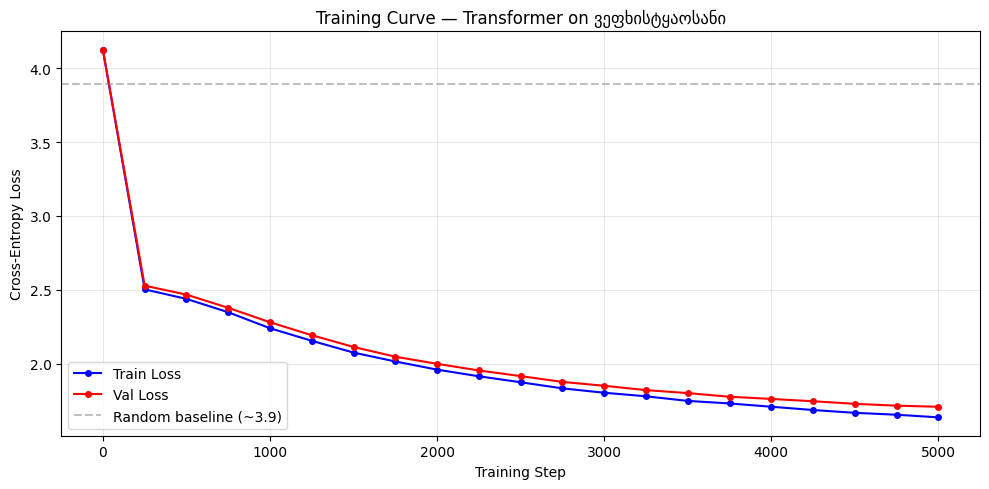

Final train loss: 1.6359
Final val loss:   1.7076
Gap: 0.0717 (smaller = less overfitting)


In [29]:
# Plot training curve
plt.figure(figsize=(10, 5))
plt.plot(steps_recorded, train_losses, 'b-o', label='Train Loss', markersize=4)
plt.plot(steps_recorded, val_losses, 'r-o', label='Val Loss', markersize=4)
plt.xlabel('Training Step')
plt.ylabel('Cross-Entropy Loss')
plt.title('Training Curve — Transformer on ვეფხისტყაოსანი')
plt.legend()
plt.grid(True, alpha=0.3)

# Add annotations
plt.axhline(y=-np.log(1/vocab_size), color='gray', linestyle='--', alpha=0.5, label=f'Random baseline (~{-np.log(1/vocab_size):.1f})')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Final train loss: {train_losses[-1]:.4f}")
print(f"Final val loss:   {val_losses[-1]:.4f}")
print(f"Gap: {val_losses[-1] - train_losses[-1]:.4f} (smaller = less overfitting)")

In [30]:
# Generation 1: Unconditional — start from a single zero token
print("=" * 70)
print("UNCONDITIONAL GENERATION (after training):")
print("=" * 70)
context = torch.zeros((1, 1), dtype=torch.long, device=device)
generated_text = decode(m.generate(context, max_new_tokens=500)[0].tolist())
print(generated_text)
print("=" * 70)

UNCONDITIONAL GENERATION (after training):

და ხაზა აბჯობს ჩემთვისა მხნევსა, ხროველთა ხელება.

მოგლა მოძგულს, არა არ მოჰახინდეს, ზარმად დახელსა ყვათასა;
გამიმგვანდორდის სისხმისა სიტყვან კად,-ლიცა ბრიდისა”.
მოუთქვენის, ანავის იარის, კაცსა რიდთა მისსნა,
მაგრი თავისა შამოსა შემოწყავ, სიტყვარებოდეს,
და ამიცა რასსა ვერ მე შემამკლდა ეცე ამოსისა”,

კვლა ერთი, თავის მისმყენი სახუო, ბედთა გამინდარად,

თვალი ბერჯითა ერთო სობითა, ავთანდილითა არია!
და ფატმან სობა ვითა მზე ტურფალი მბო შეულისა,
მოვედით თავთანდილი ჭიმი იტყოვით ზეცხსენ თმაგრა.

ფრონით ვი


In [31]:
# Generation 2: Prompted — seed with a known line from the poem
print("=" * 70)
print("PROMPTED GENERATION (starting from a known line):")
print("=" * 70)

prompts = [
    "რომელმან შექმნა სამყარო",
    "ვეფხის",
    "მეფისა მზის თამარისა",
]

for prompt in prompts:
    print(f"\n--- Prompt: '{prompt}' ---")
    context = torch.tensor([encode(prompt)], dtype=torch.long, device=device)
    generated = decode(m.generate(context, max_new_tokens=200)[0].tolist())
    print(generated)
    print()

PROMPTED GENERATION (starting from a known line):

--- Prompt: 'რომელმან შექმნა სამყარო' ---
რომელმან შექმნა სამყაროდი თამათასა,
ლარდ შავთვა ცრემლთა უფროდვეს, ცნობა ძმა-გამითქმი იშსა,
რაშლიტი ვეროდის ზეო, დან აქება, თვით მონითა სლევან;
მასმავიდეს და სჯული, სითხლებობელად დაქრილებით,
და ვერ სიამცდილი და წერთნისა დროკ


--- Prompt: 'ვეფხის' ---
ვეფხის, სჯურთად წყარ ისგან ყულსა შეჯდომარე წვამალისა;
ამა გამექამდის და ივჰკვდირვეს ხელითა ახლოს.
ესე დაგვიდინთა ტახი ვაწჟა მოდრილი, თმოდეს ჩვენ სმენცა ნია.

“იმართო კაცთა ამტერდსა თუცთა შუგან ცრომლსა ფისხლ


--- Prompt: 'მეფისა მზის თამარისა' ---
მეფისა მზის თამარისა ეცლისა;
და შევნე ელვა მისა უთხრა:ისი არვე, სხვის რო ნისითა:
და მცოცეს, ეხლთა ალთქვის ვთქვას: “ჰალვებრისანოსა მედსა”.

ითხრა: “, რაც ვის გმაგრთა ამბოსა სალილსა ბასრო,
შეჯდორ” ბელმან, შენს დაუბნარელი, 



In [32]:
# Generation 3: Temperature experiment
print("=" * 70)
print("TEMPERATURE EXPERIMENT:")
print("=" * 70)

prompt = "რომელმან შექმნა"
context = torch.tensor([encode(prompt)], dtype=torch.long, device=device)

for temp in [0.5, 0.8, 1.0, 1.5]:
    print(f"\n--- Temperature = {temp} {'(conservative)' if temp < 1 else '(standard)' if temp == 1 else '(creative)'} ---")
    generated = decode(m.generate(context.clone(), max_new_tokens=150, temperature=temp)[0].tolist())
    print(generated)

print("\n" + "=" * 70)
print("Lower temperature → more predictable, repetitive")
print("Higher temperature → more diverse, but potentially less coherent")
print("This is exactly the 'temperature' parameter you'll learn about in Week 4!")

TEMPERATURE EXPERIMENT:

--- Temperature = 0.5 (conservative) ---
რომელმან შექმნა მისთვის ხამს, მისმენოდა,
და მისმენის შემოვიდა ჩემი მას მართ ვით ნახვლების,
და დავიდეს მოყვენეს მოვიდა, მაგრალი მისსა ამის სიკარი.

“მის უთხრა: “ვის მ

--- Temperature = 0.8 (conservative) ---
რომელმან შექმნა, სადგები მეფისად ჩემთა მზემთასა.

“აქარ ძება საკვირი ვითხრობათ დაიამივლარნი; ელვისა მინდორსა.
მეშინი მე ფესათის დაავსდილ მისი მზღვამისა დარვით,
თანუ 

--- Temperature = 1.0 (standard) ---
რომელმან შექმნა ტანი, მივაჭვრით მით რბნელად გეაწვებნები,
იგონდა მლისა, ღმე დავბრალდით, მე გარნასწავლე”.
და მაწვდილს, ამასა ნადგედ მისცა - რისმე სიად;
სპატირთა: “ნურა

--- Temperature = 1.5 (creative) ---
რომელმან შექმნალობა ნანიტთა მონვიყო».”
დევახალნიცახლეთ, ეთითვით? თუ დაშქრები მდუღერ;
კიმ–აბნი ბუღთვა
ჩარდიმცარა მეღო ჩდაჯველთანი, ღმერთისა, გვერვიდენს.

დავათთ, ავჯ”

Lower temperature → more predictable, repetitive
Higher temperature → more diverse, but potentially less coherent
This is exactly the 'temperature' par

## 4.2 What Did Our Model Actually Learn?

Let's analyze what the model captured:

**Character-level patterns:**
- Georgian letter frequencies and common bigrams/trigrams
- Vowel-consonant patterns typical of Georgian

**Word-level patterns:**
- Common Georgian word structures (suffixes, prefixes)
- Frequent words from the poem (names, common verbs)

**Structural patterns:**
- Line breaks and stanza structure (4-line quatrains)
- Comma and punctuation placement
- The rhyming scheme of ვეფხისტყაოსანი (shairi meter — AAAB)

**What it does NOT capture well:**
- True semantic meaning or logical coherence
- Long-range dependencies beyond the context window
- Grammatical correctness beyond local patterns

> 💡 With only ~0.2M-1M parameters trained for a few minutes, we can't expect perfection. But the fact that it learns Georgian-like text structure at ALL demonstrates the power of the transformer architecture!

---
# Part 5: Visualizing Attention & Understanding What the Model Sees ⏱️ ~8 min
---

Let's peek inside our trained model and visualize what the attention heads actually learned.

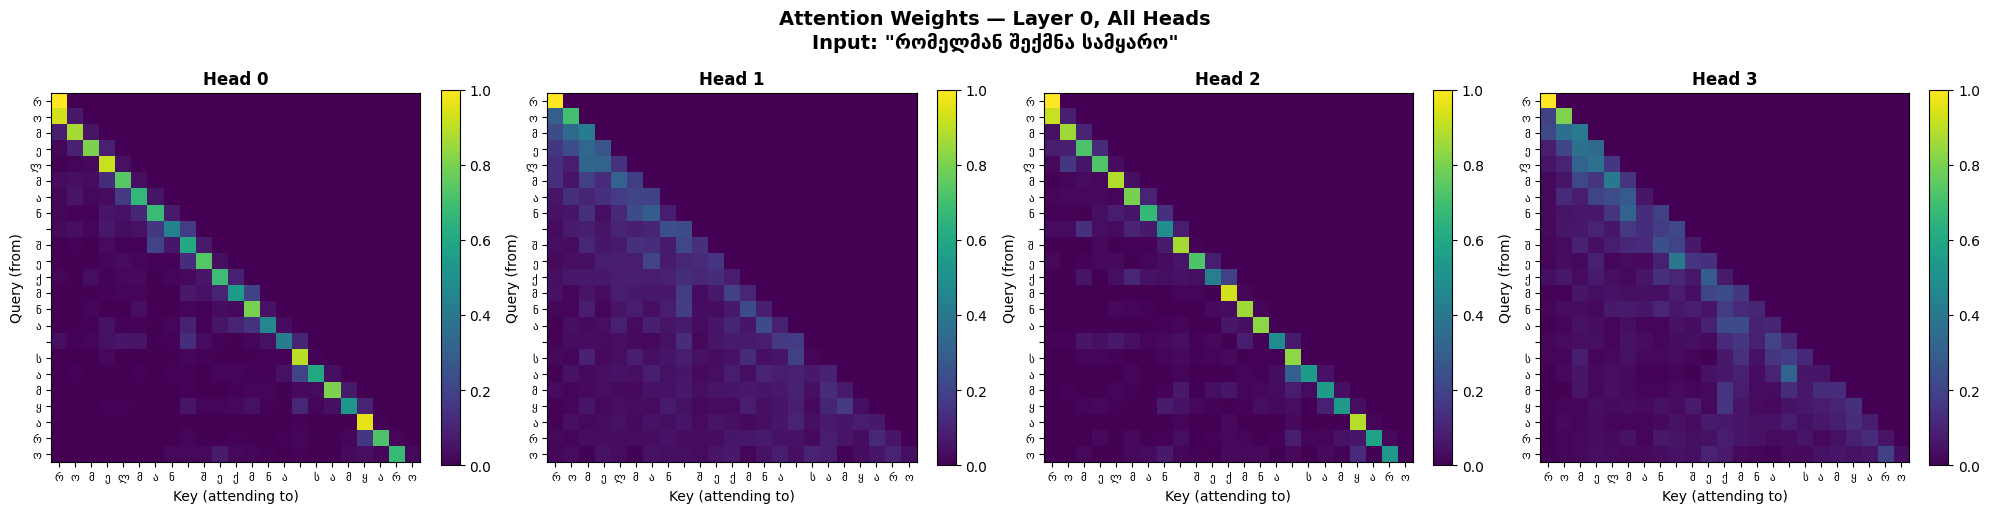

Each head learns different attention patterns!
Some heads may focus on nearby characters, others on structural patterns.


In [33]:
# Visualize attention patterns from our TRAINED model
# We'll hook into the attention weights of each head in the first block

def get_attention_maps(model, text_input, layer_idx=0):
    """Extract attention weights from a specific layer of the trained model."""
    model.eval()
    tokens = torch.tensor([encode(text_input)], dtype=torch.long, device=device)
    B, T = tokens.shape

    # Forward pass through embeddings
    tok_emb = model.token_embedding_table(tokens)
    pos_emb = model.position_embedding_table(torch.arange(T, device=device))
    x = tok_emb + pos_emb

    # Pass through blocks up to the target layer
    for i, block in enumerate(model.blocks):
        if i == layer_idx:
            # Extract attention weights from this block's attention heads
            attention_maps = []
            for head in block.sa.heads:
                k = head.key(block.ln1(x))
                q = head.query(block.ln1(x))
                C_head = k.shape[-1]
                wei = q @ k.transpose(-2, -1) * C_head**-0.5
                wei = wei.masked_fill(head.tril[:T, :T] == 0, float('-inf'))
                wei = F.softmax(wei, dim=-1)
                attention_maps.append(wei[0].detach().cpu())
            return attention_maps, list(text_input)
        x = block(x)
    return None, None

# Visualize attention heads on a sample Georgian text
sample_text = "რომელმან შექმნა სამყარო"
attn_maps, chars_list = get_attention_maps(model, sample_text, layer_idx=0)

if attn_maps:
    n_heads = len(attn_maps)
    fig, axes = plt.subplots(1, n_heads, figsize=(5 * n_heads, 5))
    if n_heads == 1:
        axes = [axes]

    for head_idx, (attn, ax) in enumerate(zip(attn_maps, axes)):
        T_len = len(chars_list)
        im = ax.imshow(attn[:T_len, :T_len].numpy(), cmap='viridis', interpolation='nearest')
        ax.set_xticks(range(T_len))
        ax.set_yticks(range(T_len))
        ax.set_xticklabels(chars_list, fontsize=8)
        ax.set_yticklabels(chars_list, fontsize=8)
        ax.set_title(f'Head {head_idx}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Key (attending to)')
        ax.set_ylabel('Query (from)')
        plt.colorbar(im, ax=ax, fraction=0.046)

    plt.suptitle(f'Attention Weights — Layer 0, All Heads\nInput: "{sample_text}"',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


---
# Part 6: Transformer Variants — One Architecture, Many Applications
---

The transformer we just built is the **decoder-only (GPT-style)** variant. But the same core attention mechanism powers very different models. Let's explore the three main variants and see how minimal the code changes are.

## 6.1 GPT (Decoder) vs BERT (Encoder) — The One-Line Difference

The fundamental difference between GPT and BERT is just **one line of code**: the causal mask.

```python
# GPT (Decoder) — autoregressive, left-to-right only
wei = wei.masked_fill(tril == 0, float('-inf'))  # ← THIS LINE

# BERT (Encoder) — bidirectional, sees all tokens
# Just remove that line! Every token can attend to every other token.
```

**GPT is a generative model** — it predicts the next token, one at a time, left-to-right.
- Pre-trained with **Next Token Prediction (NTP)**
- Used for: text generation, chatbots, code completion

**BERT is an understanding model** — it sees the entire input at once.
- Pre-trained with **Masked Language Modeling (MLM)**: randomly mask 15% of tokens, predict them
- Also uses **Next Sentence Prediction (NSP)**: given two sentences, are they consecutive?
- Used for: classification, NER, embedding/search, question answering

> 💡 In HW Part 1, you fine-tuned BERT for sentiment classification using `AutoModelForSequenceClassification`. That model uses bidirectional attention (no causal mask) to "understand" the full sentence before classifying it.

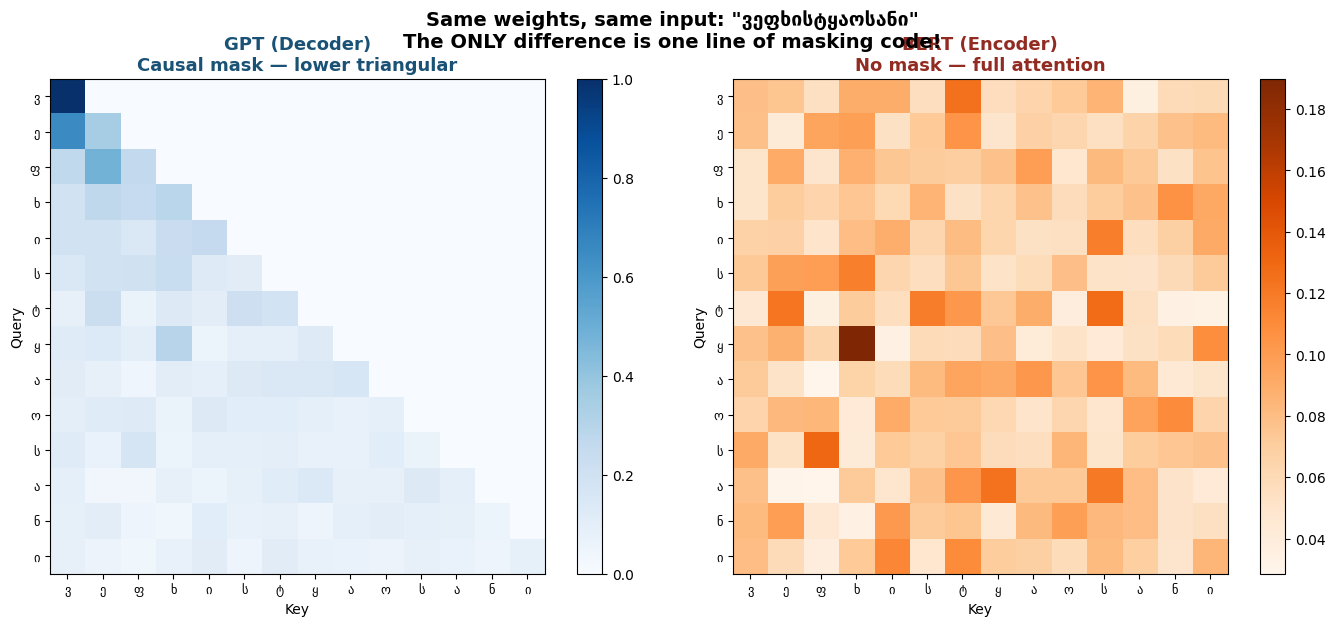

In [39]:
# Live demo: GPT-style vs BERT-style attention on the same input
# We modify our Head class to optionally disable the causal mask

class FlexibleHead(nn.Module):
    """Attention head that can switch between causal (GPT) and bidirectional (BERT)."""

    def __init__(self, head_size, causal=True):
        super().__init__()
        self.key   = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.causal = causal
        if causal:
            self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.transpose(-2, -1) * C**-0.5

        if self.causal:
            wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))

        wei = F.softmax(wei, dim=-1)
        v = self.value(x)
        return wei, wei @ v

# Create one GPT-style and one BERT-style head with same random weights
torch.manual_seed(42)
gpt_head = FlexibleHead(32, causal=True).to(device)
bert_head = FlexibleHead(32, causal=False).to(device)
# Copy weights so the only difference is the mask
bert_head.load_state_dict(gpt_head.state_dict(), strict=False)

# Run on a sample
sample = "ვეფხისტყაოსანი"
tokens = torch.tensor([encode(sample)], dtype=torch.long, device=device)
x_emb = model.token_embedding_table(tokens) + model.position_embedding_table(torch.arange(tokens.shape[1], device=device))

gpt_weights, _ = gpt_head(x_emb)
bert_weights, _ = bert_head(x_emb)

# Visualize side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
chars_vis = list(sample)
T_vis = len(chars_vis)

im1 = ax1.imshow(gpt_weights[0, :T_vis, :T_vis].detach().cpu().numpy(), cmap='Blues')
ax1.set_xticks(range(T_vis)); ax1.set_xticklabels(chars_vis, fontsize=9)
ax1.set_yticks(range(T_vis)); ax1.set_yticklabels(chars_vis, fontsize=9)
ax1.set_title('GPT (Decoder)\nCausal mask — lower triangular', fontsize=13, fontweight='bold', color='#1a5276')
ax1.set_xlabel('Key'); ax1.set_ylabel('Query')
plt.colorbar(im1, ax=ax1)

im2 = ax2.imshow(bert_weights[0, :T_vis, :T_vis].detach().cpu().numpy(), cmap='Oranges')
ax2.set_xticks(range(T_vis)); ax2.set_xticklabels(chars_vis, fontsize=9)
ax2.set_yticks(range(T_vis)); ax2.set_yticklabels(chars_vis, fontsize=9)
ax2.set_title('BERT (Encoder)\nNo mask — full attention', fontsize=13, fontweight='bold', color='#922b21')
ax2.set_xlabel('Key'); ax2.set_ylabel('Query')
plt.colorbar(im2, ax=ax2)

plt.suptitle(f'Same weights, same input: "{sample}"\nThe ONLY difference is one line of masking code!',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 6.2 Encoder-Decoder (T5, Original Transformer)

The **original Transformer** from "Attention Is All You Need" uses BOTH an encoder and a decoder:

```
Source: "გამარჯობა, როგორ ხარ?"     ←── Encoder (bidirectional attention)
                                          │
                                    Cross-Attention
                                          │
Target: "<START> Hello, how are you?"  ←── Decoder (causal + cross-attention)
```

**Key addition:** The decoder has a second attention layer — **cross-attention** — where:
- **Queries** come from the decoder (the generated sequence so far)
- **Keys and Values** come from the encoder (the full source input)

This is perfect for **sequence-to-sequence** tasks: translation, summarization, etc.

**Modern examples:** T5, BART, mBART, Flan-T5

> In our GPT model, Q/K/V all come from the same input — that's why it's called **self**-attention. Cross-attention uses Q from one source and K/V from another — that's **cross**-attention.

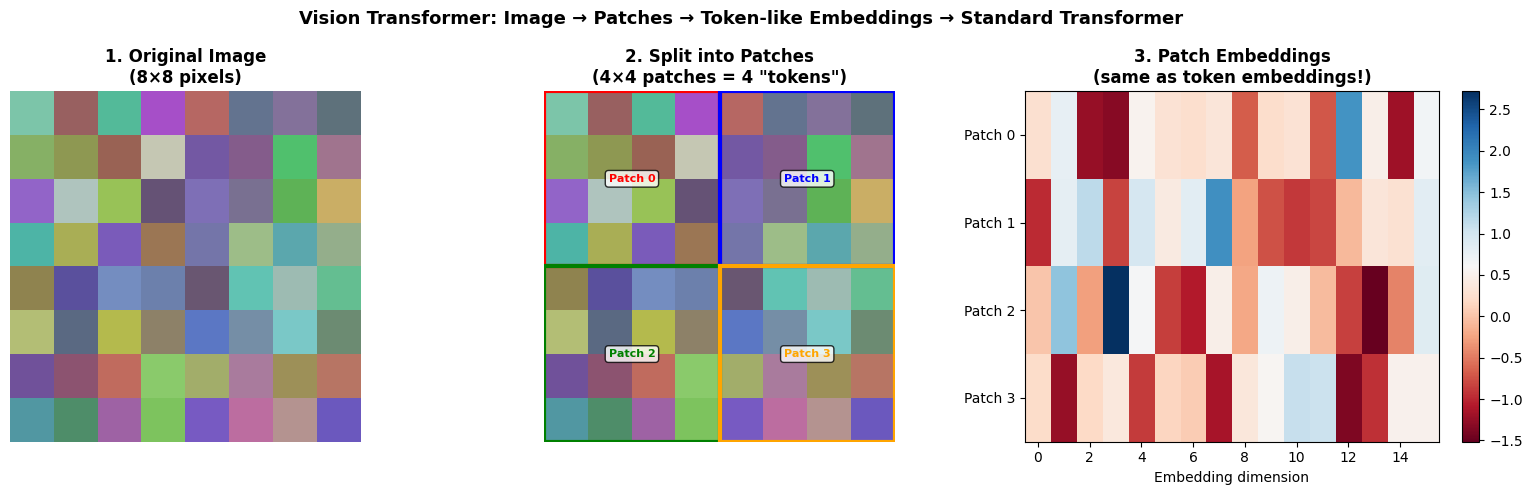

After step 3, these patch embeddings are processed by a STANDARD transformer encoder
— the exact same architecture as BERT (bidirectional attention, no causal mask).


In [40]:
# Mini-demo: ViT-style patch embedding (conceptual)
# Show how an image gets turned into "tokens" for a transformer

from matplotlib.patches import Rectangle

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Original "image" (random for demo)
np.random.seed(42)
img = np.random.rand(8, 8, 3) * 0.5 + 0.3  # 8x8 RGB image
axes[0].imshow(img)
axes[0].set_title('1. Original Image\n(8×8 pixels)', fontsize=12, fontweight='bold')
axes[0].axis('off')

# 2. Split into patches
axes[1].imshow(img)
patch_size = 4  # 4x4 patches → 4 patches total
colors = ['red', 'blue', 'green', 'orange']
labels = ['Patch 0', 'Patch 1', 'Patch 2', 'Patch 3']
idx = 0
for i in range(0, 8, patch_size):
    for j in range(0, 8, patch_size):
        rect = Rectangle((j-0.5, i-0.5), patch_size, patch_size,
                         linewidth=3, edgecolor=colors[idx], facecolor='none')
        axes[1].add_patch(rect)
        axes[1].text(j + patch_size/2 - 0.5, i + patch_size/2 - 0.5, labels[idx],
                    ha='center', va='center', fontsize=8, fontweight='bold',
                    color=colors[idx],
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        idx += 1
axes[1].set_title('2. Split into Patches\n(4×4 patches = 4 "tokens")', fontsize=12, fontweight='bold')
axes[1].axis('off')

# 3. Sequence of patch embeddings (like text tokens)
patch_embeddings = np.random.randn(4, 16)  # 4 patches, 16d embeddings
axes[2].imshow(patch_embeddings, aspect='auto', cmap='RdBu')
axes[2].set_yticks(range(4))
axes[2].set_yticklabels([f'Patch {i}' for i in range(4)])
axes[2].set_xlabel('Embedding dimension')
axes[2].set_title('3. Patch Embeddings\n(same as token embeddings!)', fontsize=12, fontweight='bold')
plt.colorbar(axes[2].images[0], ax=axes[2], fraction=0.046)

plt.suptitle('Vision Transformer: Image → Patches → Token-like Embeddings → Standard Transformer',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print("After step 3, these patch embeddings are processed by a STANDARD transformer encoder")
print("— the exact same architecture as BERT (bidirectional attention, no causal mask).")

---
# Part 7: Key Takeaways & What's Next
---

### What We Built Today
1. **Character-level tokenizer** — `encode()` / `decode()` for Georgian text
2. **Self-attention from scratch** — from naive averaging → matrix trick → softmax → Q,K,V
3. **Full GPT-style transformer** — Head → MultiHead → FFN → Block → GPT model (~0.2-1M params)
4. **Trained on ვეფხისტყაოსანი** — learned Georgian character/word/structure patterns
5. **Generated new Georgian text** — with temperature control

### The Five Key Insights
1. **Transformers are modular** — complex behavior from simple, repeated blocks
2. **Self-attention = data-dependent weighted averaging** — Q,K,V + softmax + scaling
3. **Causal mask is the ONLY difference between GPT and BERT** — one line of code
4. **Same architecture scales from 0.2M to 175B+ parameters** — our model ≡ GPT-4 structurally
5. **Transformers are universal** — same attention works for text (GPT/BERT), images (ViT), audio, protein folding, ...

### What's Coming in Week 4
- **Decoding algorithms:** Top-k, Top-p (nucleus sampling), Beam search
- **Temperature** in detail (we already previewed it!)
- **LLM pipeline:** Pre-training → SFT → RLHF
- **API calling, Structured Output, Tool calling** — using LLMs in practice

### Further Reading
- Andrej Karpathy's "Let's build GPT" video: https://www.youtube.com/watch?v=kCc8FmEb1nY
- Jay Alammar's "The Illustrated Transformer": https://jalammar.github.io/illustrated-transformer/
- "Attention Is All You Need" paper: https://arxiv.org/abs/1706.03762
- "An Image is Worth 16x16 Words" (ViT): https://arxiv.org/abs/2010.11929
- Positional encoding deep-dive: https://kazemnejad.com/blog/transformer_architecture_positional_encoding/

---
# Bonus: Experiment on Your Own!
---

Try modifying the hyperparameters and re-training to see how they affect the output quality:

| Experiment | What to change | Expected effect |
|-----------|---------------|-----------------|
| **Bigger model** | `n_embd=256, n_head=8, n_layer=6` | Better quality, slower training |
| **Longer context** | `block_size=256` | Captures longer-range patterns (line/stanza structure) |
| **More training** | `max_iters=10000` | Lower loss, but watch for overfitting |
| **No dropout** | `dropout=0.0` | Faster convergence but may overfit more |
| **Higher learning rate** | `learning_rate=1e-3` | Faster initial progress, but may diverge |
| **Tiny model** | `n_embd=32, n_head=2, n_layer=2` | Fast training, poor quality — shows why scale matters |

**Challenge ideas:**
1. Add **top-k sampling** to the `generate()` method (preview of Week 4!)
2. Try training on a **different Georgian text** or combine multiple texts
3. Implement **sinusoidal positional encoding** instead of learned embeddings
4. Add a **learning rate scheduler** (warmup + cosine decay)
5. Try removing the causal mask and training as a **masked language model** (BERT-style)